 # 1. Data preparation and exploration


<strong>1.1 Creating Spark Session<strong>

In [1]:
from pyspark import SparkConf
from pyspark.sql import SparkSession

master = "local[2]"
app_name = "Assignment2A"
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

#change the max partition bytes from 128M to 30M ; the size of files is 60MB, therefore 2 partitions will be made for each file
spark = SparkSession.builder.config(conf=spark_conf).config("spark.sql.files.maxPartitionBytes", 32010240).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

<strong>1.2 Loading the data<strong>


In [2]:
#specify the schema before reading to speed up loading
from pyspark.sql.types import *
from pyspark.sql.functions import *
# read in ["MINFLT","MAJFLT","VSTEXT","RSIZE","VGROW","RGROW"] as stringtype instead to avoid mismatch

memoryFields = StructType([StructField("ts", IntegerType(), True),
                StructField("PID", IntegerType(), True),
                StructField("MINFLT", StringType(), False),
                StructField("MAJFLT", StringType(), False),
                StructField("VSTEXT", StringType(), True),
                StructField("VSIZE", DoubleType(), True),
                StructField("RSIZE", StringType(), True),
                StructField("VGROW", StringType(), True),
                StructField("RGROW", StringType(), True),
                StructField("MEM", DoubleType(), True),
                StructField("CMD", StringType(), True),
                StructField("attack", IntegerType(), True),
                StructField("type", StringType(), True)
               ])

processFields = StructType([StructField("ts", IntegerType(), True),
                StructField("PID", IntegerType(), True),
                StructField("TRUN", IntegerType(), True),
                StructField("TSLPI", IntegerType(), True),
                StructField("TSLPU", IntegerType(), True),
                StructField("POLI", StringType(), True),
                StructField("NICE", IntegerType(), True),
                StructField("PRI", IntegerType(), True),
                StructField("RTPR", IntegerType(), True),
                StructField("CPUNR", IntegerType(), True),
                StructField("Status", StringType(), True),
                StructField("EXC", IntegerType(), True),
                StructField("State", StringType(), True),
                StructField("CPU", DoubleType(), True),
                StructField("CMD", StringType(), True),
                StructField("attack", IntegerType(), True),
                StructField("type", StringType(), True)
               ])
# loading the data with predefined schema structure
df_process = spark.read.csv("linux_process_*", header=True, schema = processFields)
df_memory = spark.read.csv("linux_memory_*", header=True, schema = memoryFields)


In [3]:
# calculating the value of alpha
# for column in ["MINFLT","MAJFLT","VSTEXT","RSIZE","RGROW"]:
#     df_memory.select(column).filter(col(column).contains("M") | col(column).contains("K") | col(column).contains("G")).show()
    
def cal_alpha(row):
    if 'K' in row:
        row = str(float(row[:-1]) * 1000)
    elif 'M' in row:
        row = str(float(row[:-1]) * 1000000)
    elif 'G' in row:
        row = str(float(row[:-1]) * 1000000000)
    return row

cal_alpha = udf(cal_alpha,StringType())

for column in ["MINFLT","MAJFLT","VSTEXT","RSIZE","RGROW"]:
    df_memory = df_memory.withColumn(column,cal_alpha(df_memory[column]))
    df_memory = df_memory.withColumn(column, df_memory[column].cast(DoubleType()))

In [4]:
# #handling unformated data in VGROW
# from pyspark.sql.functions import *

# # removing spaces in column "VGROW"  and convert it's datatype first
# df_memory = df_memory.withColumn("VGROW", regexp_replace(df_memory["VGROW"], " ", ""))
# df_memory = df_memory.withColumn("VGROW", df_memory["VGROW"].cast(DoubleType()))
# df_memory.select("VGROW").filter(col("VGROW").contains(" ")).show()

def remove_space(row):
    if " " in row:
        row = row.replace(" ","")
    return row

remove_space = udf(remove_space,StringType())
df_memory = df_memory.withColumn("VGROW",cal_alpha(df_memory["VGROW"]))
df_memory = df_memory.withColumn("VGROW",remove_space(df_memory["VGROW"]))
df_memory = df_memory.withColumn("VGROW",df_memory["VGROW"].cast(DoubleType()))

In [51]:
from pyspark.sql.functions import isnan, when, count, col
df_memory.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_memory.columns]).show()

+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|CMD|attack|type|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
|  0|  0|     0|     0|     0|    0|    0|    0|    0|  0|  0|     0|   0|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+



In [52]:
df_process.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_process.columns]).show()

+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
| ts|PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|RTPR|CPUNR|Status|EXC|State|CPU|CMD|attack|type|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
|  0|  0|   0|    0|    0|   0|   0|  0|   0|    0|     0|  0|    0|  0|  0|     0|   0|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+



In [53]:
df_memory.printSchema()
df_process.printSchema()

root
 |-- ts: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- MINFLT: double (nullable = true)
 |-- MAJFLT: double (nullable = true)
 |-- VSTEXT: double (nullable = true)
 |-- VSIZE: double (nullable = true)
 |-- RSIZE: double (nullable = true)
 |-- VGROW: double (nullable = true)
 |-- RGROW: double (nullable = true)
 |-- MEM: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: integer (nullable = true)
 |-- type: string (nullable = true)

root
 |-- ts: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- TRUN: integer (nullable = true)
 |-- TSLPI: integer (nullable = true)
 |-- TSLPU: integer (nullable = true)
 |-- POLI: string (nullable = true)
 |-- NICE: integer (nullable = true)
 |-- PRI: integer (nullable = true)
 |-- RTPR: integer (nullable = true)
 |-- CPUNR: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- EXC: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- CPU: double (nullable = tru

<strong>1.3 Exploring the data (15%)<strong>

<strong>1. Show the count of attack and non-attack in each activity based on the column
“attack”, then show the count of each kind of attack in process activity based on the
column “type”.<strong>

<strong>Question about "Class imbalanced" Answer:<strong>

<strong>There is class imbalanced problem in each two dataset; <strong>
<strong>1. Since as shown in the counting of attack/unattack number for both two dataset; the amount of negative sample is much more higher than positive sample; E.g. in "memory" positive sample is about 5 times lower than negative one, same in "process"<strong>


In [54]:
#process counting base on attack 
df_process.groupBy("attack").count().show()
df_process.count()

+------+-------+
|attack|  count|
+------+-------+
|     1| 291364|
|     0|1636604|
+------+-------+



1927968

In [55]:
#process counting based on differnet attack type
df_process.filter(col("attack") == 1).groupBy("type").count().show()

+---------+-----+
|     type|count|
+---------+-----+
|      xss|17759|
| password|51409|
| scanning|38449|
|     ddos|71603|
|     mitm|  112|
|injection|41311|
|      dos|70721|
+---------+-----+



In [56]:
#memory counting base on attack 
df_memory.groupBy("attack").count().show()

+------+-------+
|attack|  count|
+------+-------+
|     1| 205623|
|     0|1794377|
+------+-------+



In [57]:
#memory counting based on differnet attack type
df_memory.filter(col("attack") == 1).groupBy("type").count().show()

+---------+-----+
|     type|count|
+---------+-----+
| password|26016|
|     ddos|45689|
|     mitm|  112|
|injection|58523|
|      dos|75283|
+---------+-----+



<strong>2. For each numeric feature in each activity, show the basic statistics (including count,
mean, stddev, min, max); for each non-numeric feature in each activity, display the
top-10 values and the corresponding counts.
○ No need to show the labels at “attack” or “type” column<strong>

#1 For processing DF

In [58]:
# data of processing
num_col_pro = [c[0] for c in df_process.dtypes if c[1] != "string"]
str_col_pro = [c for c in df_process.columns if c not in num_col_pro]
df_num_pro = df_process.select([c for c in num_col_pro if c != "attack"])
df_str_pro = df_process.select([c for c in str_col_pro if c != "type"])
df_num_pro.describe().show()
# print(str_col_pro)

+-------+--------------------+-----------------+-------------------+------------------+--------------------+-----------------+------------------+-------+------------------+--------------------+-------------------+
|summary|                  ts|              PID|               TRUN|             TSLPI|               TSLPU|             NICE|               PRI|   RTPR|             CPUNR|                 EXC|                CPU|
+-------+--------------------+-----------------+-------------------+------------------+--------------------+-----------------+------------------+-------+------------------+--------------------+-------------------+
|  count|             1927968|          1927968|            1927968|           1927968|             1927968|          1927968|           1927968|1927968|           1927968|             1927968|            1927968|
|   mean|1.5563198311840394E9|5068.709770597852| 0.0632287465352122| 3.508334163222626|3.610018423542299...|4.634469555511295|111.26826741937626

In [59]:
#for each non-numeric feature in each activity, display the top-10 values and the corresponding counts
def show_top10_for_each_col(df):
    for c in df.columns:
        df.groupBy(c).count().sort("count",ascending = False).show(10)
show_top10_for_each_col(df_str_pro)

+----+-------+
|POLI|  count|
+----+-------+
|norm|1861558|
|   0|  53216|
|   -|  13194|
+----+-------+

+------+-------+
|Status|  count|
+------+-------+
|     -|1416322|
|     0| 438984|
|    NE|  48602|
|     N|  23313|
|    NS|    743|
|     C|      3|
|    NC|      1|
+------+-------+

+-----+-------+
|State|  count|
+-----+-------+
|    S|1676350|
|    I|  98986|
|    R|  84753|
|    E|  66410|
|    Z|   1118|
|    D|    344|
|    T|      7|
+-----+-------+

+--------------+------+
|           CMD| count|
+--------------+------+
|          atop|441180|
|       apache2|313143|
|      vmtoolsd|112029|
|          Xorg| 66813|
|      nautilus| 63449|
|gnome-terminal| 47628|
|        compiz| 44386|
|    irqbalance| 44324|
|      ostinato| 42979|
|         drone| 41390|
+--------------+------+
only showing top 10 rows



For Memory

In [60]:
num_col_mem = [c[0] for c in df_memory.dtypes if c[1] != "string"]
str_col_mem = [c for c in df_memory.columns if c not in num_col_mem]
df_num_mem = df_process.select([c for c in num_col_pro if c != "attack"])
df_str_mem = df_process.select([c for c in str_col_pro if c != "type"])
df_num_mem.describe().show()

+-------+--------------------+-----------------+-------------------+------------------+--------------------+-----------------+------------------+-------+------------------+--------------------+-------------------+
|summary|                  ts|              PID|               TRUN|             TSLPI|               TSLPU|             NICE|               PRI|   RTPR|             CPUNR|                 EXC|                CPU|
+-------+--------------------+-----------------+-------------------+------------------+--------------------+-----------------+------------------+-------+------------------+--------------------+-------------------+
|  count|             1927968|          1927968|            1927968|           1927968|             1927968|          1927968|           1927968|1927968|           1927968|             1927968|            1927968|
|   mean|1.5563198311840394E9|5068.709770597852| 0.0632287465352122| 3.508334163222626|3.610018423542299...|4.634469555511295|111.26826741937626

In [61]:
#for each non-numeric feature in each activity, display the top-10 values and the corresponding counts
show_top10_for_each_col(df_str_mem)

+----+-------+
|POLI|  count|
+----+-------+
|norm|1861558|
|   0|  53216|
|   -|  13194|
+----+-------+

+------+-------+
|Status|  count|
+------+-------+
|     -|1416322|
|     0| 438984|
|    NE|  48602|
|     N|  23313|
|    NS|    743|
|     C|      3|
|    NC|      1|
+------+-------+

+-----+-------+
|State|  count|
+-----+-------+
|    S|1676350|
|    I|  98986|
|    R|  84753|
|    E|  66410|
|    Z|   1118|
|    D|    344|
|    T|      7|
+-----+-------+

+--------------+------+
|           CMD| count|
+--------------+------+
|          atop|441180|
|       apache2|313143|
|      vmtoolsd|112029|
|          Xorg| 66813|
|      nautilus| 63449|
|gnome-terminal| 47628|
|        compiz| 44386|
|    irqbalance| 44324|
|      ostinato| 42979|
|         drone| 41390|
+--------------+------+
only showing top 10 rows



<strong>3.For each activity, present two plots3 worthy of presenting to the StopHacking
company, describe your plots and discuss the findings from the plots<strong>

* [click here to skip analysising process and jump to Correlation-Matrix Chart](#one)

* [click here to skip analysising process and jump to Column-attack analysis chart](#two)

* [click here to skip analysising process and jump to analysis report](#three)

<h>Process:<h>
    <p>RTPR is always 0 therefore will not be included<p>

In [15]:
from pyspark.sql import *
# function to get the unorm ratio (unattack/ attack); e.g. in the initial df, the amount of attack : unattack = 1:5, therefore within a 
# column, if there is a column value makes the ration become far more larger or smaller than the norm ratio, then it means that 
# this column may be helpful to clssify the attacked/unattacked data
def check_unorm_ratio(df, norm_ratio):
#     stringColumn = [c[0] for c in df.dtypes if c[1] == "string"]
    final_dict = {}
    final_temp = []
    values = {}
    for c in df.columns:
        values.clear()
        if c not in ["PID","ts","attack","type"]:
            df_temp = df.select(c,"attack")
            df_attack = df_temp.filter(col("attack") == 1)
            unattack_top3_list = df_temp.filter(col("attack") == 0).groupBy(c).count().sort("count",ascending = False).take(3)
            for item in unattack_top3_list:
            # store the top 3 highest cloumn value in unattacked data
                values[item[c]] = item["count"]
                # fetch the corrospond count number in attacked data and calculate the ratio
            for col_value in values.keys():
                attack_count_list = df_attack.filter(col(c) == col_value).groupBy(c).count().take(1)
                #store the ratio of unAttack amount/ attack amount
                values[col_value] = values[col_value]/attack_count_list[0]["count"]
            for items in values.items():
                if items[1] >= (norm_ratio + 1.5) or items[1] <= (norm_ratio - 1.5):
                    final_temp += tuple(items)    
            final_dict[c] = final_temp
            final_temp = []
    return final_dict
unorm_ratio = check_unorm_ratio(df_process,5.6)

In [12]:
a = df_process.select("TRUN","attack").filter(col("TRUN") == 20).filter(col("attack") == 1).count()
b = df_process.select("TRUN","attack").filter(col("TRUN") == 20).filter(col("attack") == 0).count()
print(b/a)

ZeroDivisionError: division by zero

In [16]:
print(unorm_ratio)

{'TRUN': [], 'TSLPI': [], 'TSLPU': [1, 1.2606060606060605, 10, 1.6], 'POLI': ['-', 1.7544885177453027], 'NICE': [20, 8.488507106457092, 1, 3.1043139166463565], 'PRI': [100, 8.488507106457092, 0, 4.026871546438574], 'RTPR': [], 'CPUNR': [], 'Status': ['-', 8.152086537343138, '0', 2.5987309707090334], 'EXC': [1, 3.0774731823599524, 15, 2.374331550802139], 'State': [], 'CPU': [], 'CMD': ['atop', 8.49202865810366]}


In [65]:
# calculate the mean and stdev of process when attack = 1 / 0
df_process_analysis.filter(col("attack") == 1).describe().show()
df_process_analysis.filter(col("attack") == 0).describe().show()

+-------+-------------------+-----------------+-------------------+------+-----------------+------------------+------+------------------+------+-------------------+------+--------------------+-------------+------+
|summary|               TRUN|            TSLPI|              TSLPU|  POLI|             NICE|               PRI|  RTPR|             CPUNR|Status|                EXC| State|                 CPU|          CMD|attack|
+-------+-------------------+-----------------+-------------------+------+-----------------+------------------+------+------------------+------+-------------------+------+--------------------+-------------+------+
|  count|             291364|           291364|             291364|291364|           291364|            291364|291364|            291364|291364|             291364|291364|              291364|       291364|291364|
|   mean|0.05816779011820266|4.368103128732445|9.43836575554976E-4|   0.0|3.278098872887522|111.33200395381722|   0.0|1.9333273843027965|   0.0|

# memory
<p>CMD = atop时<p>
    <p>MINFLT mean： attack:unattack = 5717:440<p>
<p>MAJFLT mean: 9218253:44699<p>
<p>VSTEXT mean： attack:unattack = 412013:4562<p>
<p>VSIZE mean： attack:unattack = 4478:4498<p>
<p>RSIZE mean： attack:unattack = 171570:6780<p>
<p>VGROW mean： attack:unattack =  7761:207<p>
<p>RGROW mean： attack:unattack = 393:493<p>
<p>MEM mean： attack:unattack = 0.003745835825757:.003343834656819..<p>

In [66]:
col_analy_mem = ["MINFLT","MAJFLT","VSTEXT","VSIZE","RSIZE","VGROW","RGROW","MEM","attack"]
df_mem_analysis = df_memory.select(col_analy_mem)

df_mem_analysis.filter(col("attack") == 1).describe().show()
df_mem_analysis.filter(col("attack") == 0).describe().show()

+-------+------------------+--------------------+-----------------+------------------+------------------+------------------+------------------+--------------------+------+
|summary|            MINFLT|              MAJFLT|           VSTEXT|             VSIZE|             RSIZE|             VGROW|             RGROW|                 MEM|attack|
+-------+------------------+--------------------+-----------------+------------------+------------------+------------------+------------------+--------------------+------+
|  count|            205623|              205623|           205623|            205623|            205623|            205623|            205623|              205623|205623|
|   mean| 5717.964746161665|   9218253.935464477|412013.0236062977|4478.5158357772825|171570.38996123968|   7761.9739497527|393.79196101603424|0.003745835825757...|   1.0|
| stddev|26157.322501851948|4.4520298033613175E7|1978815.981794021| 9948.231067524222| 6032937.245317878|262014.42337658742|1388.34238972619

Correlation Matrix Calculation

In [14]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder

mem_string_input = ["CMD","type"]
mem_string_output=[f'{x}_index' for x in mem_string_input]
indexer = StringIndexer(inputCols = mem_string_input,outputCols = mem_string_output)
df_mem_indexed = indexer.fit(df_memory).transform(df_memory)


vector_col_mem = "corr_features_mem"
input_ass_mem = [c for c in df_memory.columns if c not in ["CMD","type"]]
input_ass_mem = input_ass_mem + mem_string_output
assembler = VectorAssembler(inputCols=input_ass_mem, outputCol=vector_col_mem)
df_vector_mem = assembler.transform(df_mem_indexed.select(input_ass_mem)).select(vector_col_mem)


# get correlation matrix
matrix_mem = Correlation.corr(df_vector_mem, vector_col_mem).collect()[0][0]
corrmatrix_mem = matrix_mem.toArray().tolist()
 


In [15]:

from pyspark.ml import Pipeline
categoryCols = [c[0] for c in df_process.dtypes if c[1] == "string"]
numericInputCols = [c for c in df_process.columns if c not in categoryCols]



outputCols=[f'{x}_index' for x in categoryCols]

inputIndexer = StringIndexer(inputCols=categoryCols, outputCols=outputCols)


assemblerInputs = outputCols + numericInputCols
assembler = VectorAssembler(inputCols = assemblerInputs, outputCol="corr_features_pro")

stage_1 = inputIndexer
stage_2 = assembler

pipeline = Pipeline(stages = [stage_1,stage_2])
pipelineModel = pipeline.fit(df_process)
df_vector_pro = pipelineModel.transform(df_process).select("corr_features_pro")
# df_vector_pro = pipelineModel.transform(df_process)

# get correlation matrix
matrix_pro = Correlation.corr(df_vector_pro, "corr_features_pro").collect()[0][0]
# matrix_pro = Correlation.corr(df_vector_pro, df_vector_pro.columns).collect()[0][0]
corrmatrix_pro = matrix_pro.toArray().tolist()


In [122]:
print(categoryCols)
print(numericInputCols)

['POLI', 'Status', 'State', 'CMD', 'type']
['ts', 'PID', 'TRUN', 'TSLPI', 'TSLPU', 'NICE', 'PRI', 'RTPR', 'CPUNR', 'EXC', 'CPU', 'attack']


<strong>Correlation-Matric plot<strong><a class="anchor" name="one"></a>

<ipython-input-31-4a72896edda2>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([" "]+attr)
<ipython-input-31-4a72896edda2>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([' ']+attr)


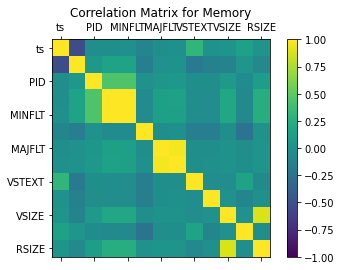

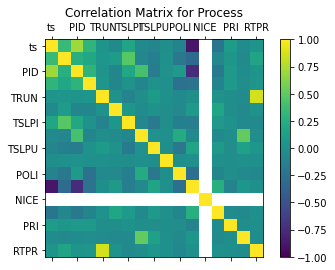

In [31]:
import matplotlib.pyplot as plt
def plot_corr_matrix(correlations,attr,fig_no):
    fig=plt.figure(fig_no)
    ax=fig.add_subplot(111)
    if "VGROW" in attr:
        df = "Memory"
    else:
        df = "Process"
    ax.set_title("Correlation Matrix for " + df)
    ax.set_xticklabels([" "]+attr)
    ax.set_yticklabels([' ']+attr)
    cax=ax.matshow(correlations,vmax=1,vmin=-1)
    fig.colorbar(cax)
    plt.show()

plot_corr_matrix(corrmatrix_mem, df_memory.columns, 234)
plot_corr_matrix(corrmatrix_pro, df_process.columns, 234)

<strong>COl-Attack<strong><a class="anchor" name="two"></a>

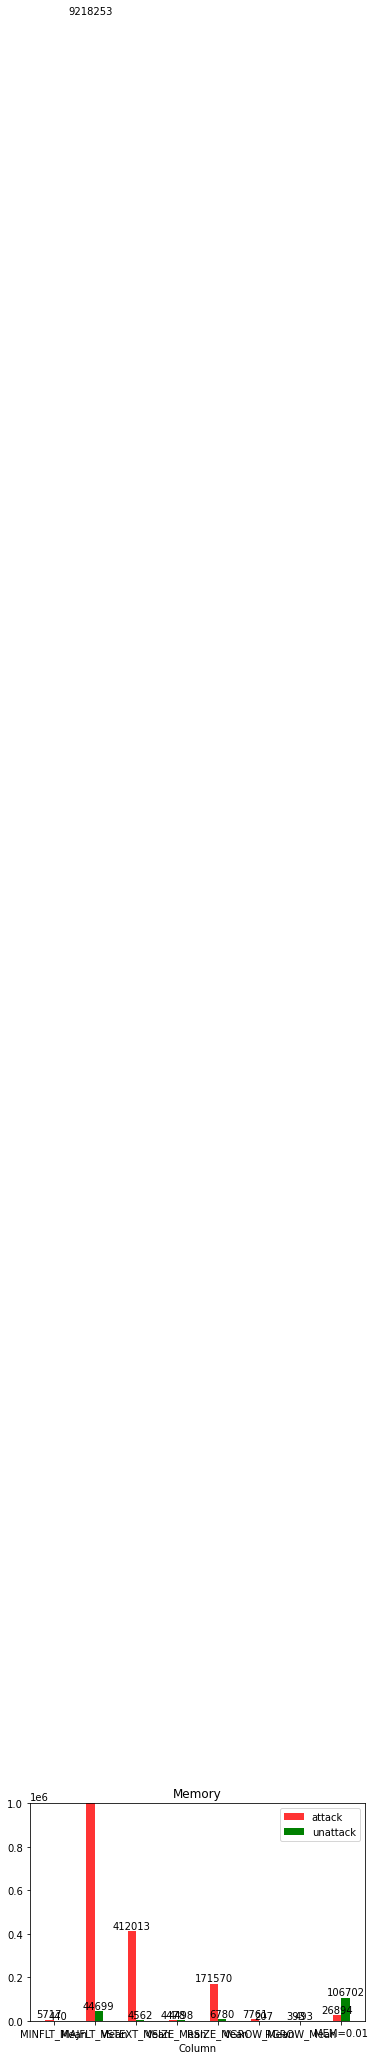

In [32]:
# 横坐标
label_list = ['MINFLT_Mean', 'MAJFLT_Mean', 'VSTEXT_Mean',"VSIZE_Mean","RSIZE_Mean",'VGROW_Mean',"RGROW_Mean","MEM=0.01"]

# 纵坐标
attack = [5717,9218253,412013,4478,171570,7761,393,26894]
unattack = [440,44699,4562,4498,6780,207,493,106702]
x = range(len(attack))

rectAttack = plt.bar(x=x, height=attack, width=0.2, alpha=0.8,
                   color='red', label="attack")
rectUnattack = plt.bar(x=[i + 0.2 for i in x], height=unattack,
                  width=0.2, color='green', label="unattack")


plt.ylim(0, 1000000)     # y range


plt.xticks([index + 0.1 for index in x], label_list)
plt.xlabel("Column")
plt.title("Memory")

for rect in rectAttack:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height +
             1, str(height), ha="center", va="bottom")
for rect in rectUnattack:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height +
             1, str(height), ha="center", va="bottom")

plt.legend(loc="upper right")
plt.show()

{'TRUN': [], 'TSLPI': [], 'TSLPU': [1, 1.2606060606060605, 10, 1.6], 'POLI': ['-', 1.7544885177453027], 'NICE': [20, 8.488507106457092, 1, 3.1043139166463565], 'PRI': [100, 8.488507106457092, 0, 4.026871546438574], 'RTPR': [], 'CPUNR': [], 'Status': ['-', 8.152086537343138, '0', 2.5987309707090334], 'EXC': [1, 3.0774731823599524, 15, 2.374331550802139], 'State': [], 'CPU': [], 'CMD': ['atop', 8.49202865810366]}

<ipython-input-26-163ef961321c>:26: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='Normal Ratio',xy=(5,5.6),xytext=(5,7),weight='bold',color='aqua',\


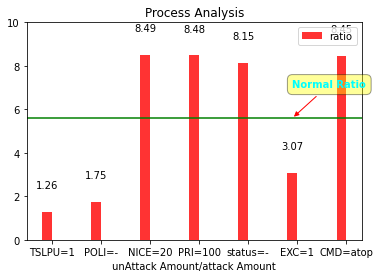

In [26]:
# 横坐标
label_list = ['TSLPU=1','POLI=-',"NICE=20","PRI=100","status=-","EXC=1","CMD=atop"]

# 纵坐标
attack = [1.26,1.75,8.49,8.48,8.15,3.07,8.45]
x = range(len(attack))

rectAttack = plt.bar(x=x, height=attack, width=0.2, alpha=0.8,
                   color='red', label="ratio")



plt.ylim(0, 10)     # y range


plt.xticks([index + 0.1 for index in x], label_list)
plt.xlabel("unAttack Amount/attack Amount")
plt.title("Process Analysis")

for rect in rectAttack:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height +
             1, str(height), ha="center", va="bottom")

plt.axhline(y=5.6, color='g', linestyle='-')
plt.annotate(s='Normal Ratio',xy=(5,5.6),xytext=(5,7),weight='bold',color='aqua',\
             arrowprops=dict(arrowstyle='-|>',connectionstyle='arc3',color='red'),\
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', ec='k',lw=1 ,alpha=0.4))

plt.legend(loc="upper right")
plt.show()

<strong>Analysis Report<strong><a class="anchor" name="three"></a>

<p>This report analysis the correlation between columns and the possibility that a column may be helpful to determine whether it is attack/unattack activity.<p>
<p>For the correlation analysis, we calculated the correlation matrix to indicate the realationship.The result is within range -1 to 1, and the more it is closer to |1|, the more correlated the columns is, 1 means 100% positive related, -1 means 100% negative related<p>
<p>For column-label analysis, we used mean value to analysis the memory dataset and the ratio of attacked amount and unattacked amount to do the analysis<p>
<p>Finally, column "RTPR" in process is not used to do the analysis since the value of it is always 0<p>
    <p>Here is the analysis detail<p>

<strong>Memery Dataset Analysis<strong>

Correlation Analysis :
<p>columns that are correlated in Memory DF(correlation value > 0.5 / < -0.5)<p>
<p>ts: VSTEXT (positive correlated)<p>
<p>PID:MINFLT(positive correlated)<p>
<p>VSIZE:RSIZE(positive correlated)<p>
<p>RSIZE:MINFLT(positive correlated)<p>

column-attack Analysis:
<p>As shown in plot, 
When a record is labeled as attack/unattack, there is huge different in the mean value among following column:<p>
['MINFLT_Mean', 'MAJFLT_Mean', 'VSTEXT_Mean',"VSIZE_Mean","RSIZE_Mean",'VGROW_Mean',"RGROW_Mean"]; 
    <p>This shows the prossibility that theses columns value may have a different range of value when it is attacked record or unattacked ones. For example, as shown in plot the mean value of VSTEXT for attacked/unattacked activity is 412013 and 4562 respectively, therefore if a record's VSTEXT value is 400000, then is would be more likely to be an attacking activity<p>
        <p>Besides, because of the nature of "MEM" value, the mean value of it is amolst same; however, when MEM = 1, there is a huge different between the amount of attack/ unattack record (26894:106702). Therefore, we would consider "MEM" is helpful to differentiate the label because for example, if the "MEM" value within a record is 1, then it is more likely to be an unattacked activity. 

<p>



<strong>Process Dataset Analysis<strong>

Correlation Analysis :
<p>ts:PID(positive correlated)<p> 
    <p>TSLPT(positive correlated)<p>
<p>TRUN:RTPR(Strong positive correlated)<p>


COL-Attack:
<p>Firstly, within the process dataset, (the total amount of unattacked data / amount of attacked) is 5.6. Therefore, if there is a column value in a column which makes the ratio far more than or less than 5.6, then we would consider it as a helpful column to classify the label since otherwise the ratio should be similar to 5.6<p>

<p>Therefore, as some picked examples shown in plot, when the columns listed in the chart equals to the specific value, the record will have a strong possibility to be attacked if the ratio is small than 5.6 or to be unattacked if the ratio larger than 5.6. For example, if column TSLPU = 1, the record is more likely to be an attack one <p>

# 2. Feature extraction and ML training

<strong>2.1 Preparing the training data and testing data (4%)<strong>

<h>1. Randomly split the dataset into 80% training data and 20% testing data for each use
case<h>

In [7]:
train_memory, test_memory = df_memory.randomSplit([0.8, 0.2], seed = 2020)
train_process, test_process = df_process.randomSplit([0.8, 0.2], seed = 2020)

<p>2. With the class imbalance observed from 1.3.1, for the binary classification use case 1
& 2, prepare rebalanced training data, with attack events and non-attack events
being 1:2 ratio, while using 20%4 attack events data from the training data from 2.1.1.
Cache the rebalanced training data, and display the count of each event's data.<p>
<p>○ Hint - you can use undersampling to get the rebalanced training data<p>

In [8]:
# firstly create new df that contains 20% of attack in training data and all unattacked records in training data 
train_memory_attack = train_memory.filter(col("attack") == 1).sample(False,0.2)
train_memory_unattack = train_memory.filter(col("attack") == 0)
train_memory_temp = train_memory_attack.union(train_memory_unattack)

train_process_attack = train_process.filter(col("attack") == 1).sample(False,0.2)
train_process_unattack = train_process.filter(col("attack") == 0)
train_process_temp = train_process_attack.union(train_process_unattack)


# define the funtion to undersample the data
#df is the df to be resampled
#ratio is ratio
#class_field is the label column
#base_class is the label column value that is regarded as positive
def resample(df,ratio,class_field,base_class):
    pos = df.filter(col(class_field)==base_class)
    neg = df.filter(col(class_field)!=base_class)
    total_pos = pos.count()
    total_neg = neg.count()
    fraction= (total_pos * ratio) / total_neg
    sampled = neg.sample(False,fraction)
    return sampled.union(pos)

train_memory_resampled = resample(train_memory_temp,2,"attack",1)
train_process_resampled = resample(train_process_temp,2,"attack",1)



In [9]:
train_memory_resampled = train_memory_resampled.cache()
train_process_resampled = train_process_resampled.cache()

In [112]:
train_memory_resampled.count()

99337

In [113]:
train_memory_resampled.filter(col("attack") == 1).count()

32987

In [114]:
train_process_resampled.count()

139729

In [115]:
train_process_resampled.filter(col("attack") == 1).count()

46698

<strong>2.2 Preparing features, labels and models (16%)<strong>

<p>1. Based on data exploration from 1.3.3, which features would you select? Discuss the
reason for selecting them and how you plan to further transform them5.<p>
<p>○ 400 words max for the discussion<p>
<p>○ Hint - things to consider include whether to scale the numeric data, whether to
choose one-hot encoding or string-indexing for a specific model<p>

# Feature Selection Report

<strong>Overall<strong>

<p>Firstly, ”PID” will not be selected in both usecases. This is because that although “PID” is coreelated with certain columns as analysis shows in 1.3.3,“PID” is a meaningless data which is just a id of process that created randomly by the system and the value of it will not be same even if it is the same process. For example, if there is a process A that do the hacking work, and in a machine of Mel the id of it might be 100, but in the another machine in Sydeny, the id of process A might be 10000. Therefore id is not helpful to classify the label<p>
<p>Next, "ts" in both dataset will be selected since the time that the process running might be helpful to classify attacking activity, for example, if a process is running in 3:00 AM, then it might be an attacking one since it is off-work time.<p>



<strong>Memory selection<strong>

<p>Selected :['ts',MINFLT','MAJFLT','VSTEXT',VSIZE','RSIZE','VGROW','RGROW','MEM','CMD']<p>
    <p>Firstly, as analysised in 1.3.3, while “MEM””CMD” sees a huge gap in amount of attck/unattck records in ceratin values, other columns has a huge gap of mean values for attack/unattack.Therefore, the gap of mean values can be helpful to classify the label. For example, if MINFLT value is 400, then it is more likely to be an attacked records, and if it is 400000, then it is more likely to be unattacked one.<p>
<p>Besides, column ts-VSTEXT,VSIZE-RSIZE,RSIZE-MINFLT is correlated which is also helpful to build the model <p>


<strong>Process selection<strong>

<p>selected:["ts",'TSLPU', 'POLI', 'NICE', 'PRI', 'Status', 'EXC', 'CMD']<p>
    <p>Firstly, As plot shown in 1.3.3, when these columns equals to a specific value, the ratio of attack amount/unattack amount is far from the normal ratio which is 5.6. Specifically, the record will have a strong possibility to be attacked if the ratio is small than 5.6 or to be unattacked if the ratio larger than 5.6<p>
        <p>Besides, ts-TSLPT is correlated as shown in 1.3.3,which is helpful to build the model<p>
            <p>Finally, althogh ts-PID, TRUN-RTPR is correlated, they are not selected since there is no unornal ratio within theses columns<p>

<strong>Transform plan:<strong>

<p>1. For string col in both usecases:<p>
<p>string indexer + one-hot encoder;<p>
<p>2. For all features including the processed string columns<p>
<p>VectorAssembler(processed categrical cols + numerical cols) + StandardScaler <p>
    <p>Explain:<p>
<p>Fisrtly use indexer to transform string to a numerical value since ML cannot recognize string values, but the indexer will has “big num” and “small num” therefore it should be further transformed to vector since ML thinks “the bigger one is better than small one”<p>

<p>Then combine all the features into one column and use StandardScaler to process the data
This is because the column values are in a wide range, using the StandardScaler can meke data be limited to a certain range and thereby eliminating the adverse effects caused by singular sample data. Therefore the process of traning data will be benifited, shorting the training time <p>



---------

<p>2. Create Transformers / Estimators for transforming / assembling the features you
selected above in 2.2.1<p>
<p>○ (Bonus Task 5%) Create a custom Transformer for the column “POLI” so that
the types of policy, [“norm”, “btch”, “idle”, “fifo”, “rr”, “0”, “-”], can be mapped to
the following numbers, [0, 1, 2, 3, 4, 5, 6].<p>

In [16]:
from pyspark.ml.classification import DecisionTreeClassifier,GBTClassifier
from pyspark.ml.feature import StandardScaler
# build the new df
col_selected_mem = ['ts','MINFLT','MAJFLT','VSTEXT','VSIZE','RSIZE','VGROW','RGROW','MEM','CMD']
col_selected_pro = ["ts",'TSLPU', 'POLI', 'NICE', 'PRI', 'Status', 'EXC', 'CMD']
df_memory_train_selected = train_memory_resampled.select(col_selected_mem + ["attack"])
df_process_train_selected = train_process_resampled.select(col_selected_pro + ["attack"])
#create transformers/estimators
# For process dataset
stringCols_pro = [c[0] for c in df_process_train_selected.dtypes if c[1] == "string"]
numericInputCols_pro = [c for c in df_process_train_selected.columns if c not in (stringCols_pro + ["attack"])]


outputCols_index_pro=[f'{x}_index' for x in stringCols_pro]
inputIndexer_pro = StringIndexer(inputCols=stringCols_pro, outputCols=outputCols_index_pro).setHandleInvalid("keep")

inputCols_OHE_pro = [x for x in outputCols_index_pro]
outputCols_OHE_pro = [f'{x}_vec' for x in stringCols_pro]
encoder = OneHotEncoder(inputCols=inputCols_OHE_pro,outputCols=outputCols_OHE_pro)

assemblerInputs_pro = outputCols_OHE_pro + numericInputCols_pro
assembler = VectorAssembler(inputCols = assemblerInputs_pro, outputCol="features")

scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')

dt = DecisionTreeClassifier(featuresCol = 'scaledFeatures', labelCol = 'attack')

GBT = GBTClassifier(featuresCol = 'scaledFeatures', labelCol = 'attack')

pro_pipeline_dt = Pipeline(stages = [inputIndexer_pro,encoder,assembler,scaler,dt])
pro_pipeline_GBT = Pipeline(stages = [inputIndexer_pro,encoder,assembler,scaler,GBT])

In [17]:
#create transformers/estimators
# For memory dataset
stringCols_mem = [c[0] for c in df_memory_train_selected.dtypes if c[1] == "string"]
numericInputCols_mem = [c for c in df_memory_train_selected.columns if c not in (stringCols_mem + ["attack"])]


outputCols_index_mem=[f'{x}_index' for x in stringCols_mem]
inputIndexer_mem = StringIndexer(inputCols=stringCols_mem, outputCols=outputCols_index_mem).setHandleInvalid("keep")

inputCols_OHE_mem = [x for x in outputCols_index_mem]
outputCols_OHE_mem = [f'{x}_vec' for x in stringCols_mem]
encoder_mem = OneHotEncoder(inputCols=inputCols_OHE_mem,outputCols=outputCols_OHE_mem)

assemblerInputs_mem = outputCols_OHE_mem + numericInputCols_mem
assembler_mem = VectorAssembler(inputCols = assemblerInputs_mem, outputCol="features")


mem_pipeline_dt = Pipeline(stages = [inputIndexer_mem,encoder_mem,assembler_mem,scaler,dt])
mem_pipeline_GBT = Pipeline(stages = [inputIndexer_mem,encoder_mem,assembler_mem,scaler,GBT])

# 2.3 Training and evaluating models (35%)

<p>1. For each use case, use the corresponding ML Pipeline from previous step to train the
models on the rebalanced training data from 2.1.2<p>
<p>○ Hint - each model training might take from 1min to 40min, depending on the
complexity of the pipeline model, the amount of training data and the VM
computing power<p>

In [18]:
mem_dt_model = mem_pipeline_dt.fit(df_memory_train_selected)
mem_GBT_model = mem_pipeline_GBT.fit(df_memory_train_selected)

In [19]:
pro_dt_model = pro_pipeline_dt.fit(df_process_train_selected)
pro_GBT_model = pro_pipeline_GBT.fit(df_process_train_selected)

<p>2. For each use case, test the models on the testing data from 2.1.1 and display the<p>
<p>count of each combination of attack label and prediction label in formats as below.<p>

In [20]:
df_memory_test_selected = test_memory.select(col_selected_mem + ["attack"])
df_process_test_selected = test_process.select(col_selected_pro + ["attack"])
mem_pred_dt = mem_dt_model.transform(df_memory_test_selected)
mem_pred_GBT = mem_GBT_model.transform(df_memory_test_selected)

In [21]:
pro_pred_dt = pro_dt_model.transform(df_process_test_selected)
pro_pred_GBT = pro_GBT_model.transform(df_process_test_selected)

In [22]:
pro_pred_GBT.groupBy("attack","prediction").count().show()

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0|  5610|
|     0|       0.0|303791|
|     1|       1.0| 52770|
|     0|       1.0| 23192|
+------+----------+------+



In [23]:
pro_pred_dt.groupBy("attack","prediction").count().show()

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0|  2399|
|     0|       0.0|296127|
|     1|       1.0| 55981|
|     0|       1.0| 30856|
+------+----------+------+



In [24]:
mem_pred_dt.groupBy("attack","prediction").count().show()

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0|  2272|
|     0|       0.0|336321|
|     1|       1.0| 38986|
|     0|       1.0| 22278|
+------+----------+------+



In [25]:
mem_pred_GBT.groupBy("attack","prediction").count().show()

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0|  2047|
|     0|       0.0|337203|
|     1|       1.0| 39211|
|     0|       1.0| 21396|
+------+----------+------+



<p>3. Compute the AUC, accuracy, recall and precision for the attack label from each<p>
<p>model testing result using pyspark MLlib / ML APIs. Discuss which metric is more
proper for measuring the model performance on identifying attacks.<p>

In [26]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

def compute_metrics(predictions,dfName):
    predictions = predictions.withColumnRenamed('attack','label')
    TN = predictions.filter('prediction = 0 AND label = 0').count()
    TP = predictions.filter('prediction = 1 AND label = 1').count()
    FN = predictions.filter('prediction = 0 AND label = 1').count()
    FP = predictions.filter('prediction = 0 AND label = 1').count()
    auc = evaluator.evaluate(predictions)
    # show confusion matrix
    # calculate metrics by the confusion matrix
    accuracy = (TP + TN) /(TP + TN + FP + FN)
    precision = TP  /(TP + FP)
    recall = TP  /(TP + FN)
    print(f'for {dfName}, auc = {auc}, accuracy = {accuracy}, precision = {precision}, recall = {recall}')


In [27]:
compute_metrics(mem_pred_dt,"mem_pred_dt")
compute_metrics(mem_pred_GBT,"mem_pred_GBT")
compute_metrics(pro_pred_dt,"pro_pred_dt")
compute_metrics(pro_pred_GBT,"pro_pred_GBT")

for mem_pred_dt, auc = 0.9606652195740144, accuracy = 0.9880374146704892, precision = 0.9449318919967037, recall = 0.9449318919967037
for mem_pred_GBT, auc = 0.9865115161827653, accuracy = 0.9892406992757051, precision = 0.9503853798051287, recall = 0.9503853798051287
for pro_pred_dt, auc = 0.9452852488283581, accuracy = 0.9865566843930895, precision = 0.9589071599862967, recall = 0.9589071599862967
for pro_pred_GBT, auc = 0.9791180541807211, accuracy = 0.9694927144142846, precision = 0.9039054470709147, recall = 0.9039054470709147


<p>4. Display the top-5 most important features in each model. Discuss which pipeline<p>
<p>model is better, and whether the feature “ts” should be included in the model6. And
visualise the ROC curve for the better model you selected for each use case.<p>

<p>1. cal the importancefeature<p>

In [141]:
# col_selected_mem 
# col_selected_pro 
def get_5_imp(model,cols,model_name):
    imp_li = list(zip(cols,model.stages[-1].featureImportances))
    imp_li.sort(key = lambda x : x[1], reverse = True)
    print(f'for {model_name},5 most importance is:{imp_li[:5]} ' )

In [142]:
get_5_imp(mem_dt_model,col_selected_mem,"mem_dt_model")
get_5_imp(mem_GBT_model,col_selected_mem,"mem_GBT_model")
get_5_imp(pro_dt_model,col_selected_pro,"pro_dt_model")
get_5_imp(pro_GBT_model,col_selected_pro,"pro_GBT_model")

for mem_dt_model,5 most importance is:[('ts', 0.0), ('MINFLT', 0.0), ('MAJFLT', 0.0), ('VSTEXT', 0.0), ('VSIZE', 0.0)] 
for mem_GBT_model,5 most importance is:[('VGROW', 0.010860276393285899), ('RGROW', 0.0034624071310414254), ('MINFLT', 0.0019084034104334983), ('RSIZE', 0.0006091105646163096), ('ts', 0.0002586749399485643)] 
for pro_dt_model,5 most importance is:[('NICE', 0.0009848580397613866), ('ts', 0.0), ('TSLPU', 0.0), ('POLI', 0.0), ('PRI', 0.0)] 
for pro_GBT_model,5 most importance is:[('NICE', 0.027402545855834858), ('PRI', 0.014430069904172884), ('EXC', 0.0008435718252139582), ('POLI', 0.000329081356292898), ('ts', 1.7633775712655442e-06)] 


In [61]:
import pyspark.sql.functions as F
import pyspark.sql.types as T
import numpy as np
import matplotlib.pyplot as plt
to_array = F.udf(lambda v: v.toArray().tolist(), T.ArrayType(T.FloatType()))


def roc(dtPredictions):
    df = dtPredictions.withColumn('probability', to_array('probability'))
    prob_df = df.select(df.probability[0].alias('negative_prob'),df.probability[1].alias('positive_prob'),'attack')
    TPR = []
    FPR = []
    th = np.linspace(0, 1, 10)
    for threshold in th:
        prob_df = prob_df.withColumn('prediction',F.when(prob_df.positive_prob > threshold,1).otherwise(0))
        TN = prob_df.filter('prediction = 0 AND attack = 0').count()
        TP = prob_df.filter('prediction = 1 AND attack = 1').count()
        FN = prob_df.filter('prediction = 0 AND attack = 1').count()
        FP = prob_df.filter('prediction = 1 AND attack = 0').count()
        tpr = TP/(TP+FN)
        fpr = FP/(FP+TN)
        TPR.append(tpr)
        FPR.append(fpr)
    return TPR, FPR

def plot_auc(df,name):
    TPR,FPR = roc(df)
    plt.plot(FPR,TPR)
    plt.xlabel("FPR")
    plt.xlabel("TPR")
    show = "ROC CURVE for" + name
    plt.title(show)
    plt.show()

<strong>Discussion<strong>

Pipeline selection

<p>Result:<p>
    <p>Memory: GBT<p>
        <p>Process: GBT<p>
<p>Reason:<p>
    <p>Overall, for both datasets, the auc,accuracy,precision and recall of GBT is always higher than that of decision tree. This means that GBT has a better performance in both datasets<p>
        <p>To be more specific, AUC represents the degree or measure of separability. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. Therefore, as the data shows, GBT has a higher ability to distinguish the result correctly<p>
            <p>Precision means how many true positive sample the positive result has, agian as the result shows, GBT has more correctly predicted samples in its positive results<p>
                <p>Accuracy tells how many records that predicted is correct, not only the positive ones but also the negative ones. GBT also has a better accuracy in both datasets<p>
                    <p>Recall means that out of all the positive classes, how much we predicted correctly. It should be high as possible.<p>

"ts" Discussion

<p>"ts" will be selected<p>
    <p>Firstly, as shown in the top 5 most important feature listed above, "ts" is included in the result in both datasets when using the GBT algorith.<p>
    <p>Besides, the timestamp of a process is meaningful and helpful for classify the label. For example, the attacking activity may concentrate on a fix period of time or fix period of days. If a process is running on the off-work time, then it is probably an attacking activity. Moreover, if the attacking activity concentrate on weekends, then the processes that have a timestamp on working days will probably be an unattacking activity.<p>
  

ROC

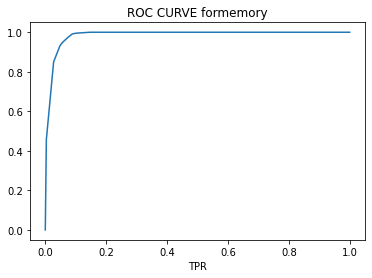

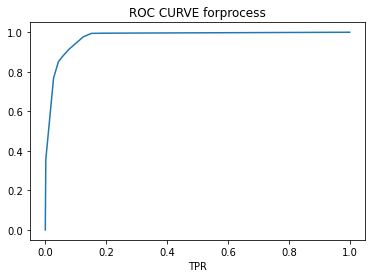

In [62]:
plot_auc(mem_pred_GBT,"memory")
plot_auc(pro_pred_GBT,"process")

<p>5. Using the pipeline model you selected in the previous step, re-train the pipeline
model using a bigger set of rebalanced training data, with attack events and
non-attack events being 1:2 ratio, while using all attack events data from the full data
for both use cases. Then persist the better models for each use case.<p>
<p>○ The models would be deployed in Part B of the assignment 2.<p>

In [40]:
df_memory_resampled_train_1 = resample(train_memory,2,"attack",1)
df_process_resampled_train_1 = resample(train_process,2,"attack",1)

In [41]:
pro_GBT_model_final = pro_pipeline_GBT.fit(df_process_resampled_train_1)
mem_GBT_model_final = mem_pipeline_GBT.fit(df_memory_resampled_train_1)

In [42]:
pro_GBT_model_final.save('pro_GBT_model_final')
mem_GBT_model_final.save('mem_GBT_model_final')

# 3. Knowledge sharing (10%)

<p>3.1 How many jobs are observed when training the KMeans clustering model following the
code below? Provide a screenshot from Spark UI for running a simple KMeans model
training. (0.5%)<p>
<p>● For example, run the following code,<p>

In [52]:
from pyspark.ml.clustering import KMeans
iris_df = spark.createDataFrame([
(4.7, 3.2, 1.3, 0.2),
(4.9, 3.1, 1.5, 0.1),
(5.4, 3.9, 1.3, 0.4),
(5.0, 3.4, 1.6, 0.4),
(5.1, 3.8, 1.6, 0.2),
(4.9, 2.4, 3.3, 1.0),
(6.6, 2.9, 4.6, 1.3),
(5.6, 3.0, 4.5, 1.5),
(5.7, 2.6, 3.5, 1.0),
(5.8, 2.6, 4.0, 1.2),
(5.8, 2.8, 5.1, 2.4),
(6.2, 2.8, 4.8, 1.8),
(6.0, 3.0, 4.8, 1.8),
(6.7, 3.1, 5.6, 2.4),
(6.7, 3.0, 5.2, 2.3),
(6.2, 3.4, 5.4, 2.3)],
['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
assembler = VectorAssembler(
inputCols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'],
outputCol='features')
kmeans = KMeans(k=3).fit(assembler.transform(iris_df))

<p>3.2 Combining the KMeans algorithm from the lecture, explain what each job in Spark UI
represents (9.5%)<p>
<p>● 300 words max for the discussion<p>

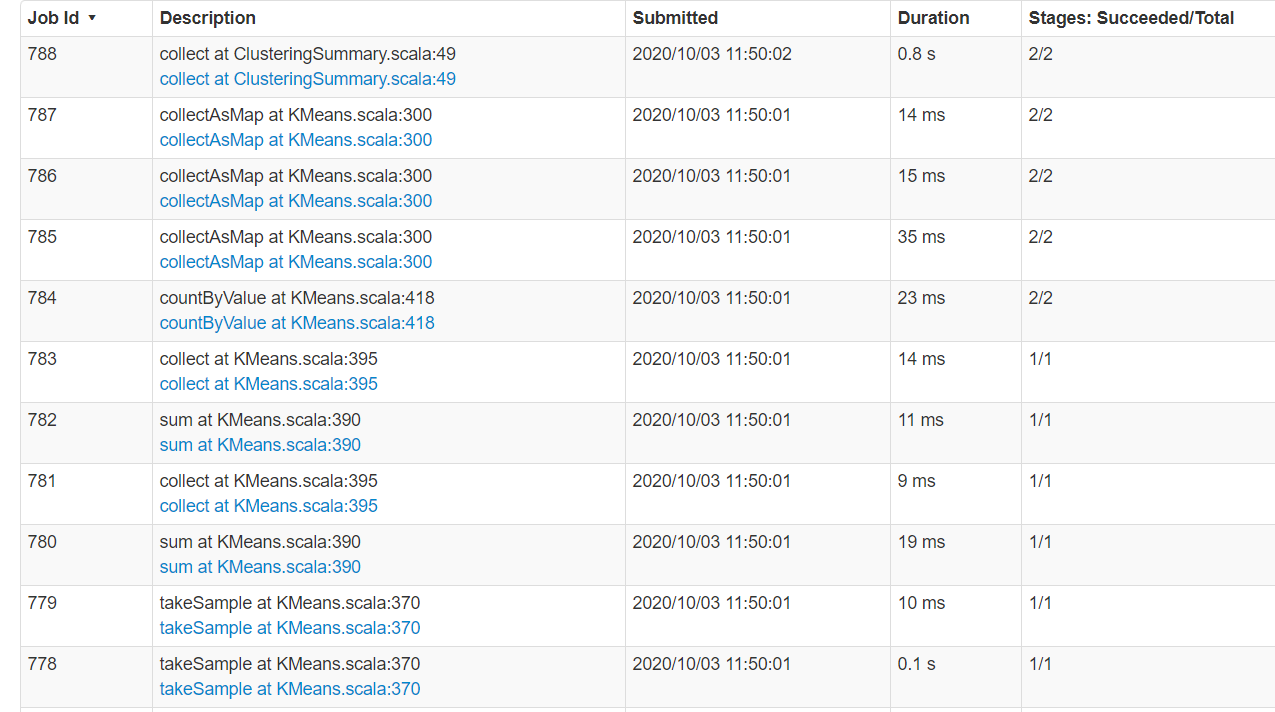

<strong>Explaination:<strong>

<p>Overall, KMeans algorithm clustering the data by calculating the distance between points and centroids, and the nearest distance makes a point be classed as a number of that centroid. After the first time cluster wich random takes the cenroids, the second iterate will calculate the mean value for all classes and take it as the new centroid, the number of centroids remains the same. Iterating this process untial the classes keeped unchange<p>
    <p>The jobs shown in the picture is the process of iteration for calculating the centroids, distance and clustering according to the distance.<p>


<p>Firstly, the dataset will be partitioned to each partitioners, then the partitioners will do the kmeans and clustering the data on its own data. For example, C1 and C2 are two cpus, after getting the data, C1 will have three classes when the first time iterate complete, C2 has as well. Apart from the classes, C1 C2 also has their own data info, i.e. the sum of each member in each clusters and the count of members in each clusters as well.<p>
    <p>Next, C1 C2 will share their data info by broadcasting it to each other to calculate the new centroid for each cluster. E.g. C1 and C2's cluster 1 have the sum for 10 and 20 respectively, 3 members and 6 members respectively. Then the new mean would be 10+20 / 3 + 6<p>
        <p>When the clusters is stabled, the iterate will finish and the final clusters will be created by collecting all the partitioners and union the individual results <p>

<p>job 778 & 779:<p>
    <p>take samples from dataset to do the KMeans clustering and partition the data to partitioners<p>

<p>job 780&781<p>

calculate the data in each partitioners for centroid and the distance between centroid and points, also compare the distance of each centoids and points to find the smallest one to determint the class.Then collect the data from each partitions

job 782&783

repeat above to iterate

job784

count the number of each values in the map

job 785-787

collect the data from each partition when the iteration is over after the clusters members doesn't change anynore

job 788

generate the summary info